In [1]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 44.04 Milhões de habitantes em SP
SP_POP = 44.04e6

In [2]:
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.head()

,Data,Vacinados,Delta
0,2021-01-19 11:16:00,3908,NaN
1,2021-01-20 14:14:00,17318,13410.0
2,2021-01-20 15:11:00,18409,1091.0
3,2021-01-20 15:19:00,18729,320.0
4,2021-01-20 15:24:00,18834,105.0


In [3]:
# Eliminando nulos e valores onde a diferença do anterior é menor que 0
# por que as vezes o site do vacinometro reporta valores errados
data = data.dropna()
data = data.drop(data.query("Delta <= 0").index)
data.sample(10)

,Data,Vacinados,Delta
466,2021-01-24 06:55:00,124707,2.0
206,2021-01-22 10:32:00,63662,331.0
432,2021-01-24 02:50:00,124582,4.0
825,2021-01-26 10:25:00,162656,683.0
335,2021-01-23 15:20:00,120144,74.0
830,2021-01-26 11:05:00,165384,763.0
812,2021-01-26 08:50:00,157567,684.0
234,2021-01-22 15:54:00,88156,41.0
673,2021-01-25 12:50:00,142890,225.0
545,2021-01-24 18:30:00,130222,25.0


In [4]:
# Vamos remover todas as entradas cuja a diferença
# da anterior (coluna delta) estiver acima de 3 desvios padrões da média (pelo mesmo motivo)
std = data.Delta.std()
mean = data.Delta.mean()
data = data.drop(data.query("Delta > @mean+2.5*@std").index)

In [5]:
# Para cada entrada, calcula em qual hora do ano ela foi computada (24*(dia_do_ano-1) + hora_do_dia)
# Dia do ano - 1 por que o primeiro dia começa na hora 0
data["HourOfYear"] = 24*(data.Data.dt.dayofyear-1) + data.Data.dt.hour
# Agrupa registros q aconteceram dentro da mesma hora e escolhe o maior valor
vacinados_hora = data.groupby("HourOfYear").max()["Vacinados"]

x, y = vacinados_hora.index, vacinados_hora
print(len(x), len(y))

121 121


In [6]:
# conjuntos de treino e teste
train, test = y[:90], y[90:]

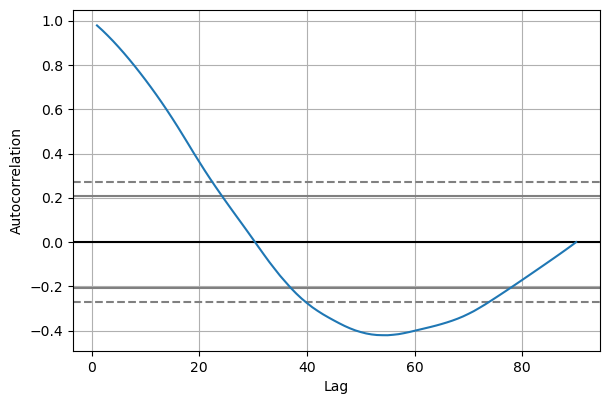

In [7]:
# Autocorrelação do conjunto de treino
fig,ax = plt.subplots(figsize=(6,4), dpi=100)
fig.tight_layout()
autocorrelation_plot(train, ax);

/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


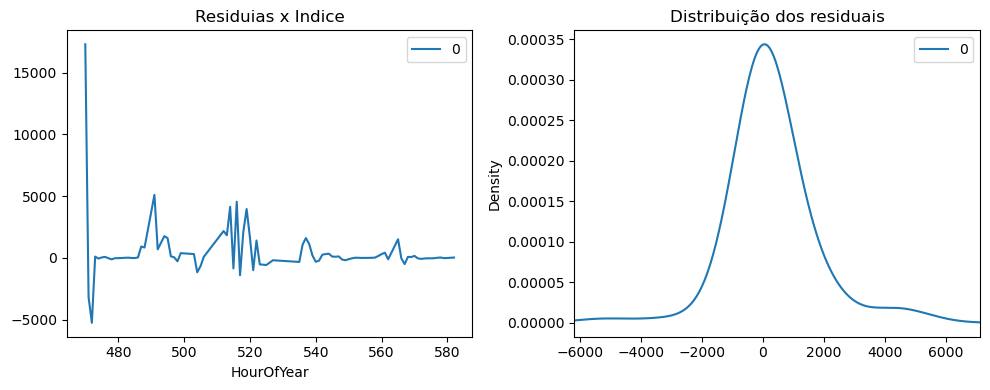

                  0
count     90.000000
mean     468.579074
std     2216.436754
min    -5249.796832
25%      -41.722718
50%       21.406953
75%      316.339682
max    17302.312247


In [8]:
# Ajustandoum modelo arima (5,1,0) com parametro de tendencia c
model = ARIMA(train, order=(5,1,0), trend='c')
model_fit = model.fit()
residuals = pd.DataFrame(model_fit.resid)

r_mean = residuals[0].mean()
r_std = residuals[0].std()
# Gŕagicos dos residuais

fig, ax = plt.subplots(ncols=2, figsize=(10,4), dpi=100)
ax[0].set(title="Residuias x Indice")
ax[1].set(title="Distribuição dos residuais",
         xlim=(r_mean-3*r_std, r_mean+3*r_std))
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', ax=ax[1])
fig.tight_layout()
plt.show()
print(residuals.describe())

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Vacinados   No. Observations:                   90
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -765.862
Date:                Wed, 27 Jan 2021   AIC                           1545.724
Time:                        12:24:16   BIC                           1563.145
Sample:                             0   HQIC                          1552.746
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6878   2200.370      0.007      0.994   -4296.958    4328.334
ar.L1          0.2535      0.050      5.118      0.000       0.156       0.351
ar.L2          0.5064      0.089      5.675      0.000       0.331       0.681
ar.L3         -0.0454      0.102     -0.445      0.656      -0.245       0.155
ar.L4          0.0084      0.126      0.067      0.947      -0.239       0.256
ar.L5         -0.0300      0.119     -0.251      0.802      -0.264       0.204
sigma2      1.414e+06   1.46e+05      9.655      0.000    1.13e+06     1.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.52   Jarque-Bera (JB):               156.83
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
"""
Faz um rolling forecast do model, adicionando um datapoint e fazendo o refit
antes de cada previsão
"""
def rolling_forecast(history, steps, model_params):
    history = history
    predictions = []
    for t in range(steps):
        model = ARIMA(history, **model_params)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test.iloc[t]
        history.append(obs)
    return predictions

In [22]:
"""
Faz o grid search para otimizar o modelo
"""
def arima_grid_search(train, test, grid, score=mean_squared_error):
    best_score = None
    best_params = None
    best_pred = None
    
    for params in grid:
        print(params)
        predictions = rolling_forecast(list(train), len(test), params)
        model_score = score(test, predictions)
        if best_score is None or model_score < best_score:
            best_params, best_score, best_pred= params, model_score, predictions
    
    return best_params, best_score, predictions

In [29]:
grid = [
    #{'order': (5,1,0), 'trend': 'c'},
    #{'order': (10,1,0), 'trend': 'c'},
    #{'order': (15,1,0), 'trend': 'c'},
    #{'order': (20,1,0), 'trend': 'c'},
    #{'order': (5,2,0), 'trend': 'c'},
    #{'order': (10,2,0), 'trend': 'c'},
    #{'order': (15,2,0), 'trend': 'c'},
    {'order': (20,2,0), 'trend': 'c'}
]

best_params, best_score, predictions = arima_grid_search(train, test, grid)

{'order': (20, 2, 0), 'trend': 'c'}


In [30]:
best_params, best_score**(1/2)

({'order': (20, 2, 0), 'trend': 'c'}, 897.272924641585)

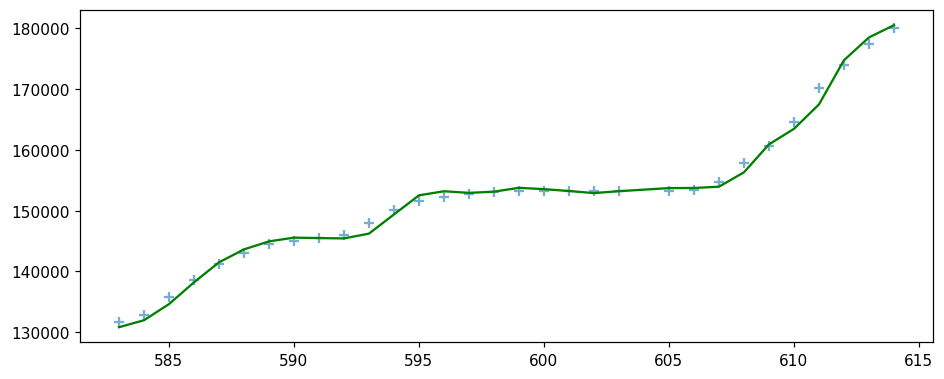

In [31]:
fig, ax = plt.subplots(figsize = (10,4), dpi=110, sharey=True)

ax.scatter(test.index, test, alpha=0.6, marker='+')
ax.plot(test.index,predictions, color='green');